In [1]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
import scanpy as sc

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy
from train import train_epoch_mmd
from utils import plot_train, preproc_filter, vis_latent_emb
from dataset import dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the dataset
We have three batches, from day 2, 4, and 7. We hope to integrate cells from 3 batches, which is to make the latent embedding of cells from three batches merge.

In [2]:
# Data
path_pool = [
    r"./data/mtx_0.mtx", 
    r'./data/GSE65525/GSM1599497_ES_d2_LIFminus.csv', 
    r'./data/GSE65525/GSM1599498_ES_d4_LIFminus.csv', 
    r'./data/GSE65525/GSM1599499_ES_d7_LIFminus.csv'
    ]

# Loading data with scanpy
data_d2 = sc.read_csv(path_pool[1])
data_d4 = sc.read_csv(path_pool[2])
data_d7 = sc.read_csv(path_pool[3])

In [3]:
# the latent embedding of three batches should be merged
# batch 1, from day 2
counts_d2 = pd.read_csv("./data/GSE65525/GSM1599497_ES_d2_LIFminus.csv", index_col = 0, header = None).T
# batch 2, from day 4
counts_d4 = pd.read_csv("./data/GSE65525/GSM1599498_ES_d4_LIFminus.csv", index_col = 0, header = None).T
# batch 3, from day 7
counts_d7 = pd.read_csv("./data/GSE65525/GSM1599499_ES_d7_LIFminus.csv", index_col = 0, header = None).T

anno_d2 = np.array(["Day 2"] * counts_d2.shape[0])
anno_d4 = np.array(["Day 4"] * counts_d4.shape[0])
anno_d7 = np.array(["Day 7"] * counts_d7.shape[0])

anno = np.concatenate([anno_d2, anno_d4, anno_d7], axis = 0)

In [4]:
# PREVIEW
load_data_d2 = data_d2.T.copy()
load_data_d4 = data_d4.T.copy()
load_data_d7 = data_d7.T.copy()

data_batch_1, data_batch_2 = preproc_filter(load_data_d2, load_data_d4, 150)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Original shape of Data1:(303, 24175) 	 Data2:(683, 24175)
FIltered shape of Data1:(303, 5166), 	 Data2: (683, 5166)


In [5]:
batch_size = 50
seed = 222
random.seed(seed)

# construct training and testing dataset for one batch (day 4)
train_data_1 = dataset(counts = data_batch_1.X, anno = anno_d2)
train_loader_1 = DataLoader(train_data_1, batch_size = batch_size, shuffle=True)

train_data_2 = dataset(counts = data_batch_2.X, anno = anno_d4)
train_loader_2 = DataLoader(train_data_2, batch_size = batch_size, shuffle = True)


In [6]:
if data_batch_1.shape != data_batch_2.shape:
    assert ValueError
net_struc = [data_batch_1.shape[1], 512, 128, 32]

encoder = Encoder(features=net_struc).to(device)
decoder = Decoder(features=net_struc[1:][::-1]).to(device)

# Three output layer of DCA
# dropoutRates = {'mean': 0.1, 'pi': 0.1, 'theta': 0.1}
output_layer = OutputLayer(net_struc[:2][::-1]).to(device)

# Define Optimizer
lr = 1e-3

#Random seed
torch.manual_seed(seed)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr)

In [7]:
factor_zinb = 1
factor_mmd = 0.3

### Training


 EPOCH 1/500 	 train loss 0.7771472742061803

 EPOCH 2/500 	 train loss 0.752290958618567

 EPOCH 3/500 	 train loss 0.7407809153641804

 EPOCH 4/500 	 train loss 0.7437941485112256

 EPOCH 5/500 	 train loss 0.7428026104917621


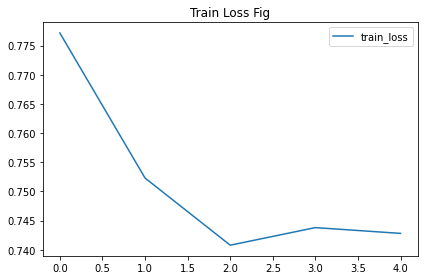


 EPOCH 6/500 	 train loss 0.7319117064523225

 EPOCH 7/500 	 train loss 0.7357536857277647

 EPOCH 8/500 	 train loss 0.7311850632771407

 EPOCH 9/500 	 train loss 0.72477656701217

 EPOCH 10/500 	 train loss 0.7267568229448678


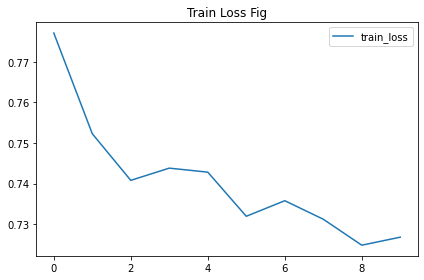


 EPOCH 11/500 	 train loss 0.7305652945741962

 EPOCH 12/500 	 train loss 0.7290790860015567

 EPOCH 13/500 	 train loss 0.7272118420490731

 EPOCH 14/500 	 train loss 0.7300279321450212

 EPOCH 15/500 	 train loss 0.7270866180017049


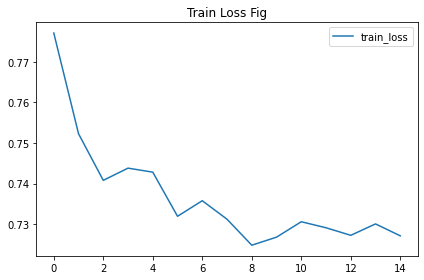


 EPOCH 16/500 	 train loss 0.7220447401795843

 EPOCH 17/500 	 train loss 0.7148891990334287

 EPOCH 18/500 	 train loss 0.7201390974592454

 EPOCH 19/500 	 train loss 0.7133204331099003

 EPOCH 20/500 	 train loss 0.7230690241646845


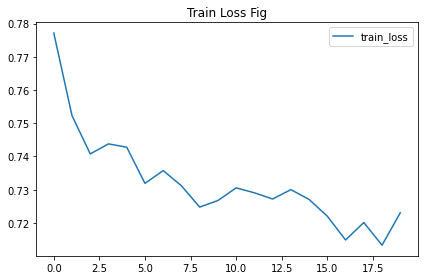


 EPOCH 21/500 	 train loss 0.7167210405809258

 EPOCH 22/500 	 train loss 0.7237783375352916

 EPOCH 23/500 	 train loss 0.712467099180316

 EPOCH 24/500 	 train loss 0.7129177433429378

 EPOCH 25/500 	 train loss 0.7075883279932608


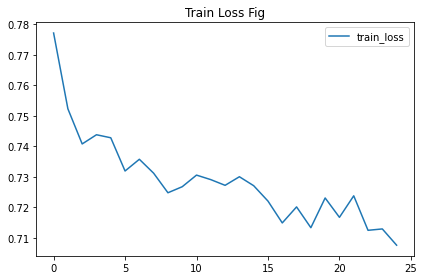


 EPOCH 26/500 	 train loss 0.717550800184999

 EPOCH 27/500 	 train loss 0.7211634255085054

 EPOCH 28/500 	 train loss 0.7076662271329672

 EPOCH 29/500 	 train loss 0.710897980743509

 EPOCH 30/500 	 train loss 0.7192491902769989


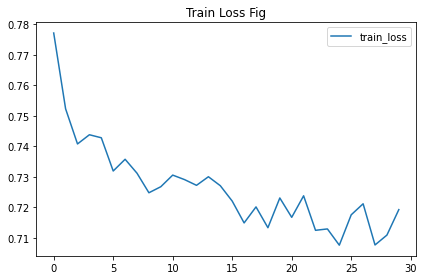


 EPOCH 31/500 	 train loss 0.7175494845550839

 EPOCH 32/500 	 train loss 0.7093192185505782

 EPOCH 33/500 	 train loss 0.7157545435940078

 EPOCH 34/500 	 train loss 0.7063081949064047

 EPOCH 35/500 	 train loss 0.7100797470646723


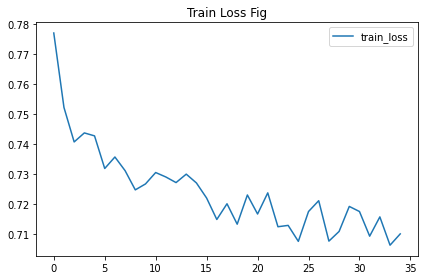


 EPOCH 36/500 	 train loss 0.7140034464719666

 EPOCH 37/500 	 train loss 0.7075988278530612

 EPOCH 38/500 	 train loss 0.7108194898850847

 EPOCH 39/500 	 train loss 0.7092351756080149

 EPOCH 40/500 	 train loss 0.7111123528811011


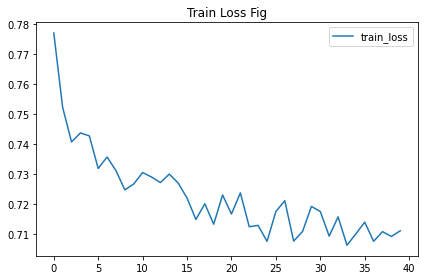


 EPOCH 41/500 	 train loss 0.7088218537887724

 EPOCH 42/500 	 train loss 0.7105277096084243

 EPOCH 43/500 	 train loss 0.7050073138951468

 EPOCH 44/500 	 train loss 0.7052772257587697

 EPOCH 45/500 	 train loss 0.7176688921333539


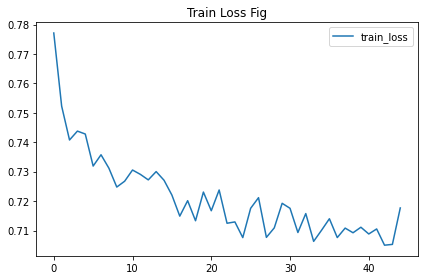


 EPOCH 46/500 	 train loss 0.711564570763717

 EPOCH 47/500 	 train loss 0.7041738906709274

 EPOCH 48/500 	 train loss 0.7152341521612489

 EPOCH 49/500 	 train loss 0.7044224817760707

 EPOCH 50/500 	 train loss 0.7029218453385255


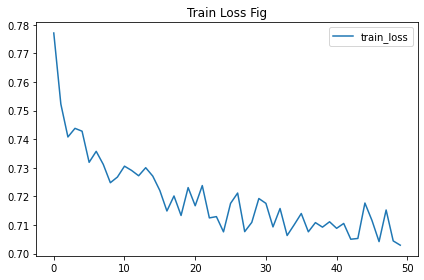


 EPOCH 51/500 	 train loss 0.7044691394264548

 EPOCH 52/500 	 train loss 0.7050510884905019

 EPOCH 53/500 	 train loss 0.7031458612322414

 EPOCH 54/500 	 train loss 0.7125147136524566

 EPOCH 55/500 	 train loss 0.7082390863903285


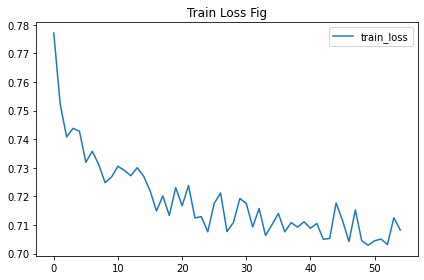


 EPOCH 56/500 	 train loss 0.7072198886682491

 EPOCH 57/500 	 train loss 0.7177331313835119

 EPOCH 58/500 	 train loss 0.708038865142923

 EPOCH 59/500 	 train loss 0.7026994220494437

 EPOCH 60/500 	 train loss 0.7016663378221367


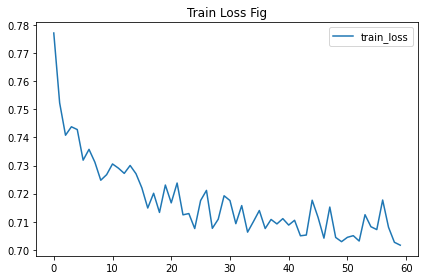


 EPOCH 61/500 	 train loss 0.7036065268437854

 EPOCH 62/500 	 train loss 0.7016021615207786

 EPOCH 63/500 	 train loss 0.7048223262572839

 EPOCH 64/500 	 train loss 0.7100879618830414

 EPOCH 65/500 	 train loss 0.7073471648464895


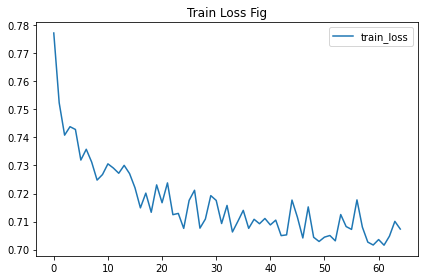


 EPOCH 66/500 	 train loss 0.7138708762996661

 EPOCH 67/500 	 train loss 0.7076946170416603

 EPOCH 68/500 	 train loss 0.7115092891277653

 EPOCH 69/500 	 train loss 0.7043524512363346

 EPOCH 70/500 	 train loss 0.7045677361315233


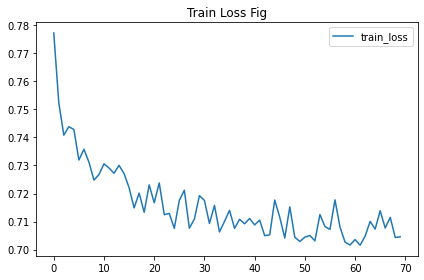


 EPOCH 71/500 	 train loss 0.6994935907546443

 EPOCH 72/500 	 train loss 0.7029985169766366

 EPOCH 73/500 	 train loss 0.7003860851325611

 EPOCH 74/500 	 train loss 0.7069523499743773

 EPOCH 75/500 	 train loss 0.7126214433424544


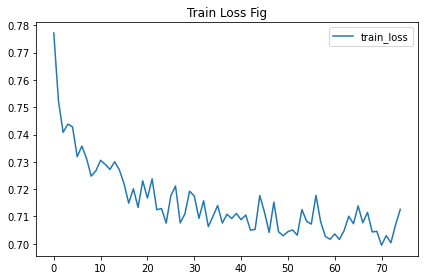


 EPOCH 76/500 	 train loss 0.7074191971580581

 EPOCH 77/500 	 train loss 0.7043271835881098

 EPOCH 78/500 	 train loss 0.7092700240635635

 EPOCH 79/500 	 train loss 0.7031014382642488

 EPOCH 80/500 	 train loss 0.710155713676226


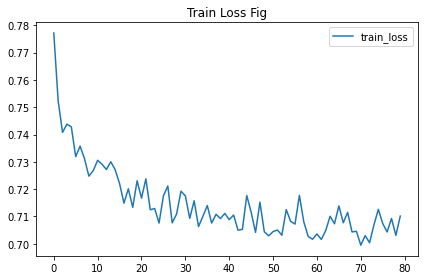


 EPOCH 81/500 	 train loss 0.7097077070683142

 EPOCH 82/500 	 train loss 0.6996680722378268

 EPOCH 83/500 	 train loss 0.7028852909705033

 EPOCH 84/500 	 train loss 0.7034023587066348

 EPOCH 85/500 	 train loss 0.7123443049566187


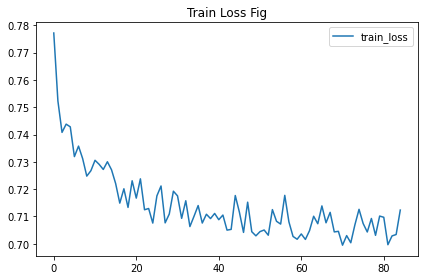


 EPOCH 86/500 	 train loss 0.7102376541288773

 EPOCH 87/500 	 train loss 0.705047355626676

 EPOCH 88/500 	 train loss 0.7002672818627688

 EPOCH 89/500 	 train loss 0.7086374830491472

 EPOCH 90/500 	 train loss 0.6986828542778595


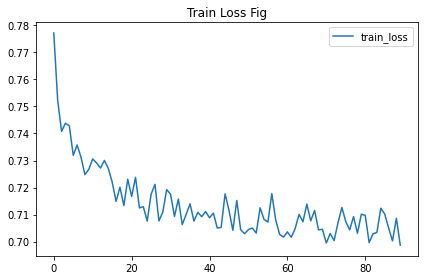


 EPOCH 91/500 	 train loss 0.7153871114497924

 EPOCH 92/500 	 train loss 0.7119033423194004

 EPOCH 93/500 	 train loss 0.7041607973205768

 EPOCH 94/500 	 train loss 0.7030110437877894

 EPOCH 95/500 	 train loss 0.7083344034629293


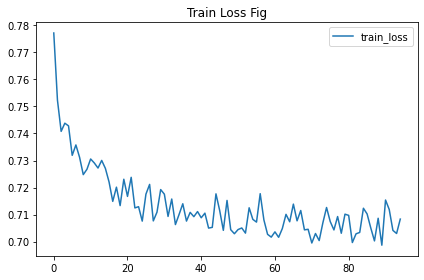


 EPOCH 96/500 	 train loss 0.7017778138516366

 EPOCH 97/500 	 train loss 0.7024546204620462

 EPOCH 98/500 	 train loss 0.693411679157723

 EPOCH 99/500 	 train loss 0.699615472220745

 EPOCH 100/500 	 train loss 0.702764888801197


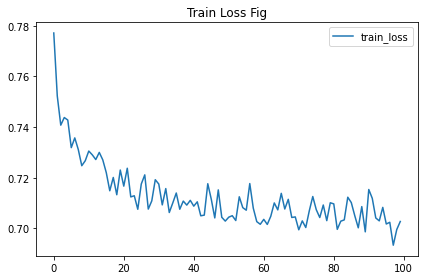


 EPOCH 101/500 	 train loss 0.702809488025829

 EPOCH 102/500 	 train loss 0.7028272269976021

 EPOCH 103/500 	 train loss 0.6983521527583056

 EPOCH 104/500 	 train loss 0.6968332485790694

 EPOCH 105/500 	 train loss 0.7019278019568315


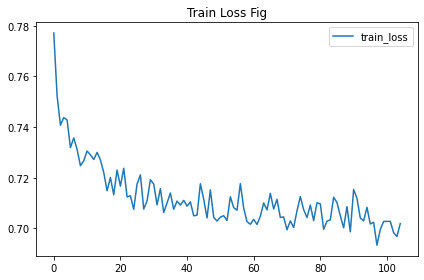


 EPOCH 106/500 	 train loss 0.6999461422658989

 EPOCH 107/500 	 train loss 0.6957308262488237

 EPOCH 108/500 	 train loss 0.7039682495318623

 EPOCH 109/500 	 train loss 0.7061555000028201

 EPOCH 110/500 	 train loss 0.6990664013148141


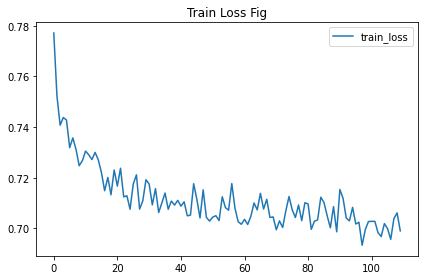


 EPOCH 111/500 	 train loss 0.7021944467777467

 EPOCH 112/500 	 train loss 0.7031783931719588

 EPOCH 113/500 	 train loss 0.6972159583969871

 EPOCH 114/500 	 train loss 0.7037452597035827

 EPOCH 115/500 	 train loss 0.6934420393638485


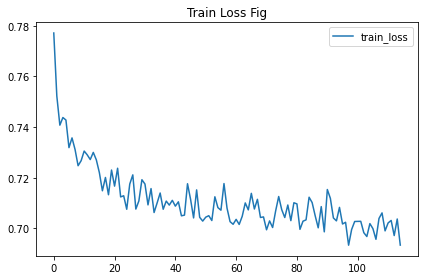


 EPOCH 116/500 	 train loss 0.6966846264628294

 EPOCH 117/500 	 train loss 0.6992396552964012

 EPOCH 118/500 	 train loss 0.6967302076887376

 EPOCH 119/500 	 train loss 0.6991478759463471

 EPOCH 120/500 	 train loss 0.7050197840523799


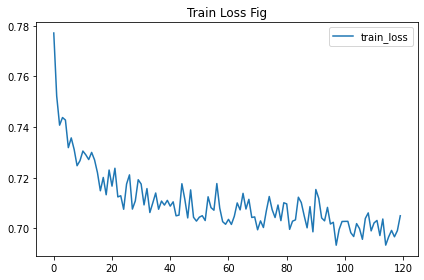


 EPOCH 121/500 	 train loss 0.7016215497511055

 EPOCH 122/500 	 train loss 0.6979114419162864

 EPOCH 123/500 	 train loss 0.6970851570859601

 EPOCH 124/500 	 train loss 0.6971746828689827

 EPOCH 125/500 	 train loss 0.7050117140162503


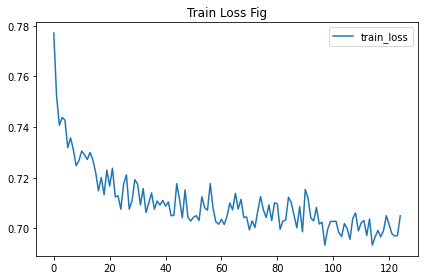


 EPOCH 126/500 	 train loss 0.7052510201734284

 EPOCH 127/500 	 train loss 0.7056090099976795

 EPOCH 128/500 	 train loss 0.7017271274780676

 EPOCH 129/500 	 train loss 0.6954898960126115

 EPOCH 130/500 	 train loss 0.697503936566142


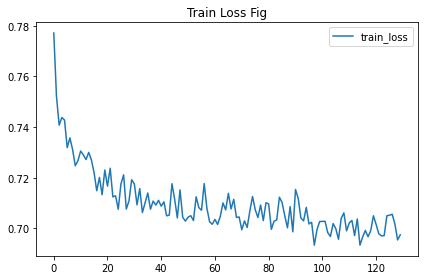


 EPOCH 131/500 	 train loss 0.7001917055337736

 EPOCH 132/500 	 train loss 0.6999773648705813

 EPOCH 133/500 	 train loss 0.6991286324982596

 EPOCH 134/500 	 train loss 0.6976685602672816

 EPOCH 135/500 	 train loss 0.7050653023294883


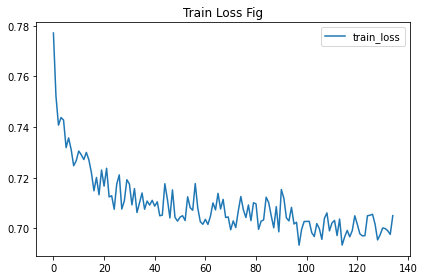


 EPOCH 136/500 	 train loss 0.7048159054797082

 EPOCH 137/500 	 train loss 0.6952261027723255

 EPOCH 138/500 	 train loss 0.7040973701099358

 EPOCH 139/500 	 train loss 0.6937679567746203

 EPOCH 140/500 	 train loss 0.698000445224271


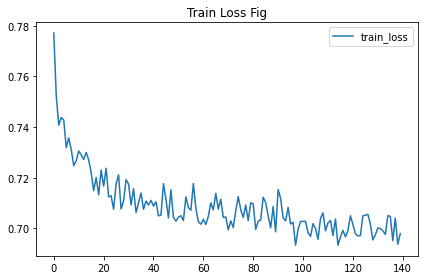


 EPOCH 141/500 	 train loss 0.7021054749441619

 EPOCH 142/500 	 train loss 0.6976641160820184

 EPOCH 143/500 	 train loss 0.6955989044491607

 EPOCH 144/500 	 train loss 0.6908858837467609

 EPOCH 145/500 	 train loss 0.6975207438956786


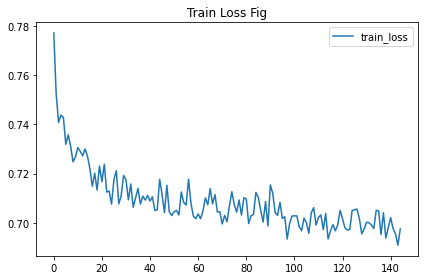


 EPOCH 146/500 	 train loss 0.7078826325167917

 EPOCH 147/500 	 train loss 0.7083560452602877

 EPOCH 148/500 	 train loss 0.7000461930882419

 EPOCH 149/500 	 train loss 0.6957813993145531

 EPOCH 150/500 	 train loss 0.6978869737178186


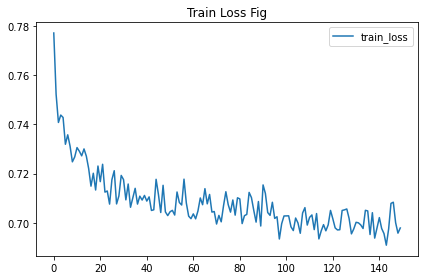


 EPOCH 151/500 	 train loss 0.6949613904795631

 EPOCH 152/500 	 train loss 0.6924463593133605

 EPOCH 153/500 	 train loss 0.6953198838942122

 EPOCH 154/500 	 train loss 0.7023342245876198

 EPOCH 155/500 	 train loss 0.6971968030772193


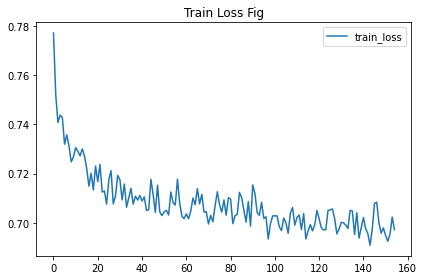


 EPOCH 156/500 	 train loss 0.6945663112224919

 EPOCH 157/500 	 train loss 0.6987101425825566

 EPOCH 158/500 	 train loss 0.6936885090944397

 EPOCH 159/500 	 train loss 0.6982736744896414

 EPOCH 160/500 	 train loss 0.6932780640353464


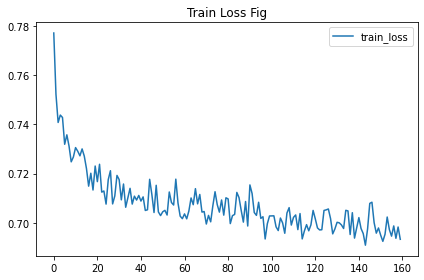


 EPOCH 161/500 	 train loss 0.7022461718065117

 EPOCH 162/500 	 train loss 0.6944635598966391

 EPOCH 163/500 	 train loss 0.6946853285182034

 EPOCH 164/500 	 train loss 0.6941081887424583

 EPOCH 165/500 	 train loss 0.6983576922526847


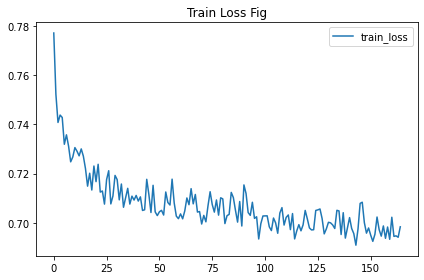


 EPOCH 166/500 	 train loss 0.6969593098454743

 EPOCH 167/500 	 train loss 0.7052157814353213

 EPOCH 168/500 	 train loss 0.6977381564602994

 EPOCH 169/500 	 train loss 0.6959833012949123

 EPOCH 170/500 	 train loss 0.7004355062352549


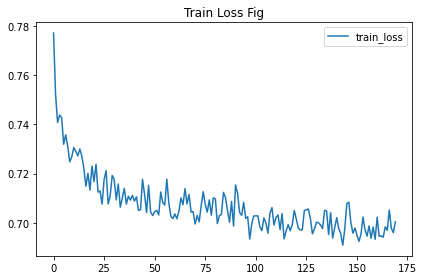


 EPOCH 171/500 	 train loss 0.6998228570415636

 EPOCH 172/500 	 train loss 0.6935878350789791

 EPOCH 173/500 	 train loss 0.6913727486487662

 EPOCH 174/500 	 train loss 0.6910581872014716

 EPOCH 175/500 	 train loss 0.6931268484285562


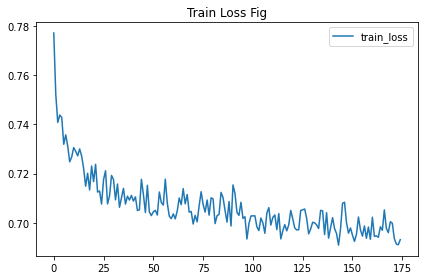


 EPOCH 176/500 	 train loss 0.6967784579437558

 EPOCH 177/500 	 train loss 0.6982476388660595

 EPOCH 178/500 	 train loss 0.6926251339046868

 EPOCH 179/500 	 train loss 0.6925616059759663

 EPOCH 180/500 	 train loss 0.6950838447797416


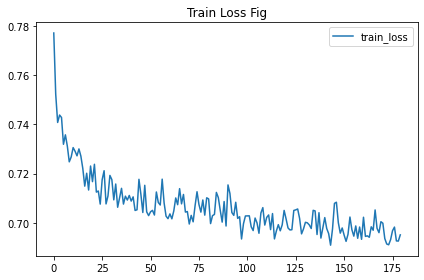


 EPOCH 181/500 	 train loss 0.6944162727582572

 EPOCH 182/500 	 train loss 0.6911437723896291

 EPOCH 183/500 	 train loss 0.6977548756615164

 EPOCH 184/500 	 train loss 0.6914469589888066

 EPOCH 185/500 	 train loss 0.6884318751470484


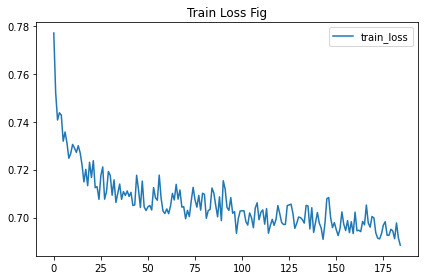


 EPOCH 186/500 	 train loss 0.6945493402260758

 EPOCH 187/500 	 train loss 0.6946725687964914

 EPOCH 188/500 	 train loss 0.6987626544713187

 EPOCH 189/500 	 train loss 0.6894958987094388

 EPOCH 190/500 	 train loss 0.6968138855282623


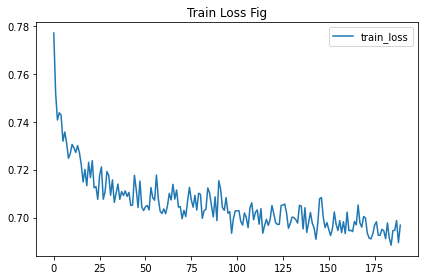


 EPOCH 191/500 	 train loss 0.6962584756781952

 EPOCH 192/500 	 train loss 0.7021498160787149

 EPOCH 193/500 	 train loss 0.6905992275024011

 EPOCH 194/500 	 train loss 0.6990385275862792

 EPOCH 195/500 	 train loss 0.7027751179811584


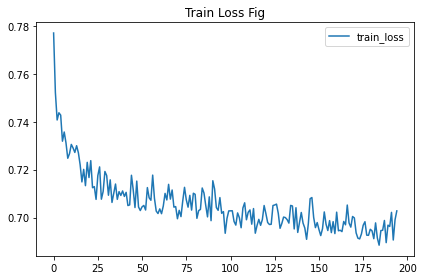


 EPOCH 196/500 	 train loss 0.6944221018171153

 EPOCH 197/500 	 train loss 0.702296788936401

 EPOCH 198/500 	 train loss 0.6990399313445138

 EPOCH 199/500 	 train loss 0.6989192710851285

 EPOCH 200/500 	 train loss 0.6924373702247544


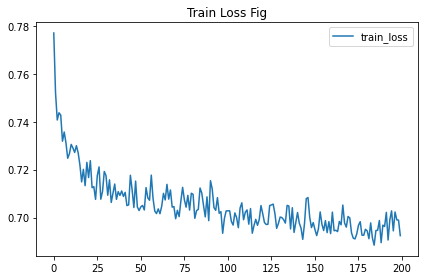


 EPOCH 201/500 	 train loss 0.6915847853858872

 EPOCH 202/500 	 train loss 0.6943551998327274

 EPOCH 203/500 	 train loss 0.696994410096222

 EPOCH 204/500 	 train loss 0.6883034407108923

 EPOCH 205/500 	 train loss 0.6905972823844885


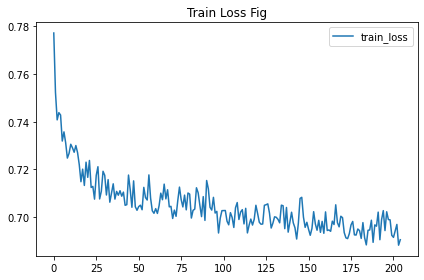


 EPOCH 206/500 	 train loss 0.6955908155283912

 EPOCH 207/500 	 train loss 0.6895727025400294

 EPOCH 208/500 	 train loss 0.6887040091033029

 EPOCH 209/500 	 train loss 0.6932206232555629

 EPOCH 210/500 	 train loss 0.7018725392055196


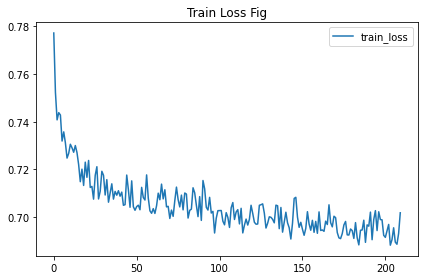


 EPOCH 211/500 	 train loss 0.6950562291412857

 EPOCH 212/500 	 train loss 0.7001057048835376

 EPOCH 213/500 	 train loss 0.6941938368794155

 EPOCH 214/500 	 train loss 0.6889229827981578

 EPOCH 215/500 	 train loss 0.6892033756369411


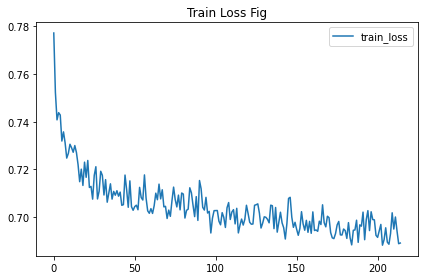


 EPOCH 216/500 	 train loss 0.6895841088625464

 EPOCH 217/500 	 train loss 0.6961570588668974

 EPOCH 218/500 	 train loss 0.6918709821040088

 EPOCH 219/500 	 train loss 0.69309400174484

 EPOCH 220/500 	 train loss 0.6915720697283352


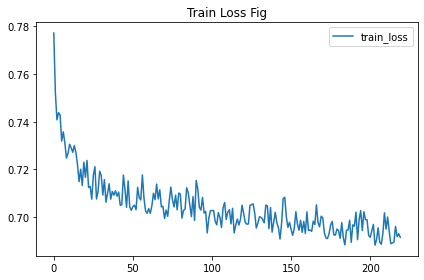


 EPOCH 221/500 	 train loss 0.6969549978526905

 EPOCH 222/500 	 train loss 0.6959318154715862

 EPOCH 223/500 	 train loss 0.689271895405483

 EPOCH 224/500 	 train loss 0.6878342077677005

 EPOCH 225/500 	 train loss 0.6954118143213858


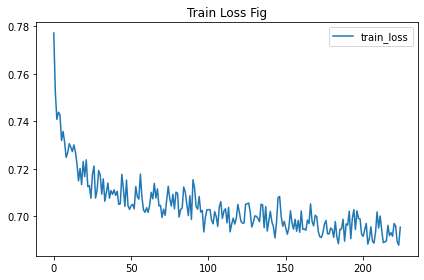


 EPOCH 226/500 	 train loss 0.6965146332290699

 EPOCH 227/500 	 train loss 0.6974708569718666

 EPOCH 228/500 	 train loss 0.6850476595434812

 EPOCH 229/500 	 train loss 0.6985267475493276

 EPOCH 230/500 	 train loss 0.6879570649401976


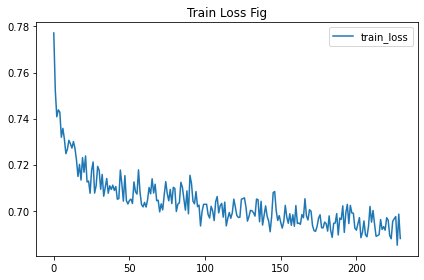


 EPOCH 231/500 	 train loss 0.6955474249207148

 EPOCH 232/500 	 train loss 0.6918091034338419

 EPOCH 233/500 	 train loss 0.689745572533938

 EPOCH 234/500 	 train loss 0.6981224148186913

 EPOCH 235/500 	 train loss 0.6882893905387854


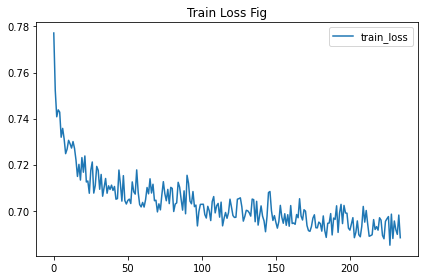


 EPOCH 236/500 	 train loss 0.6916090458533158

 EPOCH 237/500 	 train loss 0.7011559804280599

 EPOCH 238/500 	 train loss 0.6919387779613533

 EPOCH 239/500 	 train loss 0.6914784396835679

 EPOCH 240/500 	 train loss 0.6968733721440381


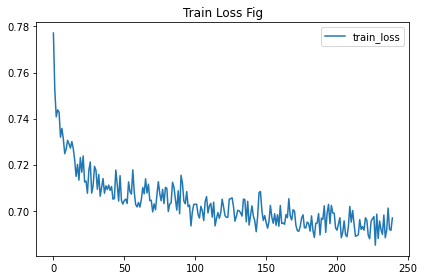


 EPOCH 241/500 	 train loss 0.6900866165412928

 EPOCH 242/500 	 train loss 0.6877496234654593

 EPOCH 243/500 	 train loss 0.6918052257877765

 EPOCH 244/500 	 train loss 0.6863778621056685

 EPOCH 245/500 	 train loss 0.6935863180129048


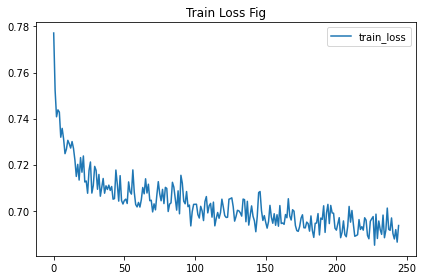


 EPOCH 246/500 	 train loss 0.6947165825972856

 EPOCH 247/500 	 train loss 0.6928520958022316

 EPOCH 248/500 	 train loss 0.6872550032713233

 EPOCH 249/500 	 train loss 0.6912311830929797

 EPOCH 250/500 	 train loss 0.6946836351954898


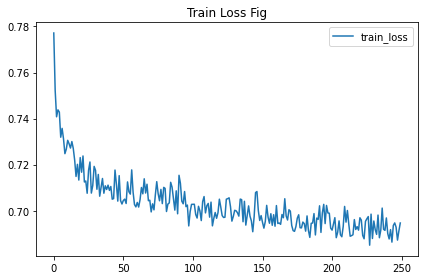


 EPOCH 251/500 	 train loss 0.6969148994672416

 EPOCH 252/500 	 train loss 0.6937493050452506

 EPOCH 253/500 	 train loss 0.6901163850287007

 EPOCH 254/500 	 train loss 0.6904745259300711

 EPOCH 255/500 	 train loss 0.6892205165951165


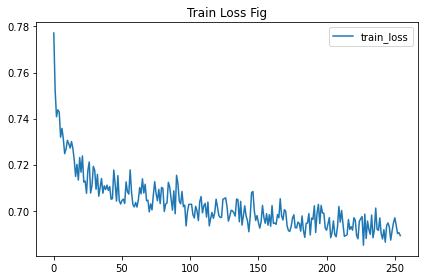


 EPOCH 256/500 	 train loss 0.6917499630364647

 EPOCH 257/500 	 train loss 0.6904786553713355

 EPOCH 258/500 	 train loss 0.6956277853584919

 EPOCH 259/500 	 train loss 0.6940585347292053

 EPOCH 260/500 	 train loss 0.6892588398244122


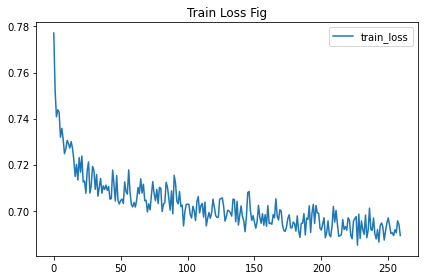


 EPOCH 261/500 	 train loss 0.6882279273306969

 EPOCH 262/500 	 train loss 0.6932113131280779

 EPOCH 263/500 	 train loss 0.698074227512473

 EPOCH 264/500 	 train loss 0.6937455658865447

 EPOCH 265/500 	 train loss 0.6843278148386738


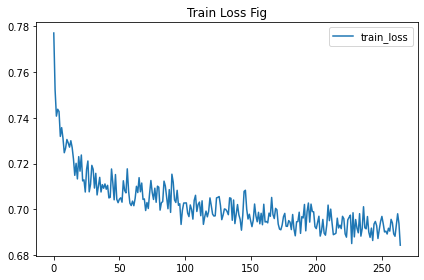


 EPOCH 266/500 	 train loss 0.6950518227253023

 EPOCH 267/500 	 train loss 0.6969478216895176

 EPOCH 268/500 	 train loss 0.6872139669487579

 EPOCH 269/500 	 train loss 0.6995378752352774

 EPOCH 270/500 	 train loss 0.6907539178829382


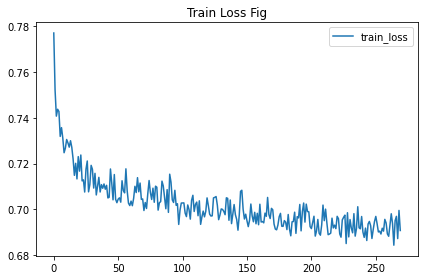


 EPOCH 271/500 	 train loss 0.6863475774381027

 EPOCH 272/500 	 train loss 0.6959517513564711

 EPOCH 273/500 	 train loss 0.6921059825632832

 EPOCH 274/500 	 train loss 0.6916336210647432

 EPOCH 275/500 	 train loss 0.6948807656568269


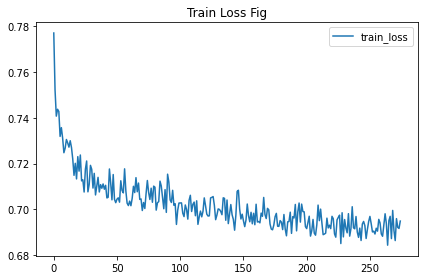


 EPOCH 276/500 	 train loss 0.6833243165472553

 EPOCH 277/500 	 train loss 0.6913077791925311

 EPOCH 278/500 	 train loss 0.6875813046697736

 EPOCH 279/500 	 train loss 0.6870509358522522

 EPOCH 280/500 	 train loss 0.6966863071957831


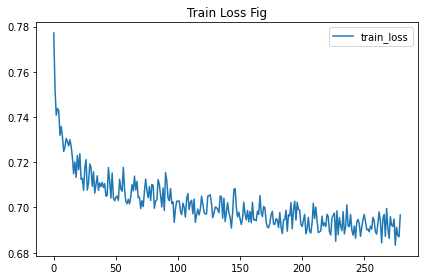


 EPOCH 281/500 	 train loss 0.6920978684629938

 EPOCH 282/500 	 train loss 0.697141955787986

 EPOCH 283/500 	 train loss 0.6863088198620887

 EPOCH 284/500 	 train loss 0.6851335280012376

 EPOCH 285/500 	 train loss 0.6967198085470168


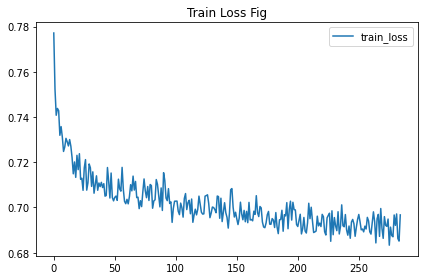


 EPOCH 286/500 	 train loss 0.6902529209753862

 EPOCH 287/500 	 train loss 0.681505536875709

 EPOCH 288/500 	 train loss 0.6923176541973656

 EPOCH 289/500 	 train loss 0.6928520643278318

 EPOCH 290/500 	 train loss 0.6936707197636267


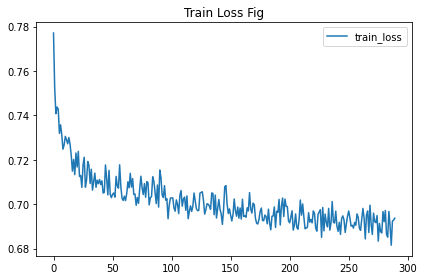


 EPOCH 291/500 	 train loss 0.6942144714959777

 EPOCH 292/500 	 train loss 0.6867546043773689

 EPOCH 293/500 	 train loss 0.693589169593534

 EPOCH 294/500 	 train loss 0.6926603222837543

 EPOCH 295/500 	 train loss 0.6855172701794715


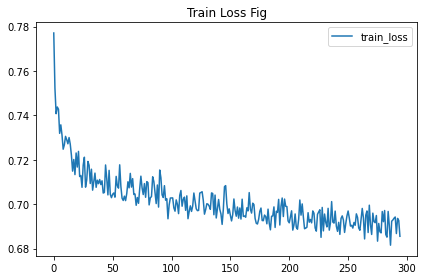


 EPOCH 296/500 	 train loss 0.6932242491064292

 EPOCH 297/500 	 train loss 0.6959008005979431

 EPOCH 298/500 	 train loss 0.6869031572499291

 EPOCH 299/500 	 train loss 0.6868158913288179

 EPOCH 300/500 	 train loss 0.6968153962994567


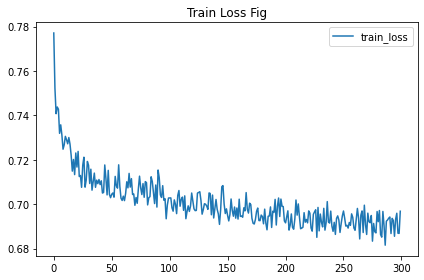


 EPOCH 301/500 	 train loss 0.6954902862951701

 EPOCH 302/500 	 train loss 0.6907167592064383

 EPOCH 303/500 	 train loss 0.6862282139239925

 EPOCH 304/500 	 train loss 0.6978883837709332

 EPOCH 305/500 	 train loss 0.6916354654645762


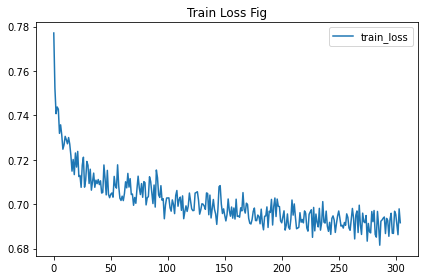


 EPOCH 306/500 	 train loss 0.6891033059299583

 EPOCH 307/500 	 train loss 0.6858231950514387

 EPOCH 308/500 	 train loss 0.6914051798704041

 EPOCH 309/500 	 train loss 0.6902007867794225

 EPOCH 310/500 	 train loss 0.6918468853034595


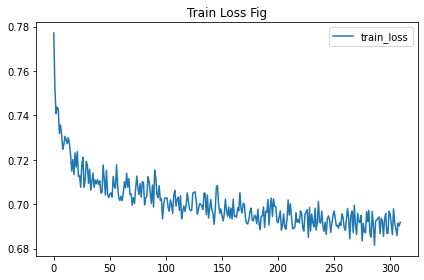


 EPOCH 311/500 	 train loss 0.697100025592464

 EPOCH 312/500 	 train loss 0.692820142991472

 EPOCH 313/500 	 train loss 0.6889728130680499

 EPOCH 314/500 	 train loss 0.6851912079864603

 EPOCH 315/500 	 train loss 0.6867470064572375


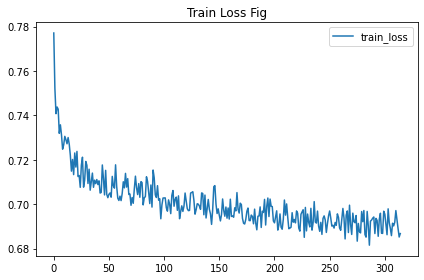


 EPOCH 316/500 	 train loss 0.6850852588615796

 EPOCH 317/500 	 train loss 0.6905936187643422

 EPOCH 318/500 	 train loss 0.6909677297762125

 EPOCH 319/500 	 train loss 0.6875473689718214

 EPOCH 320/500 	 train loss 0.6851175893651377


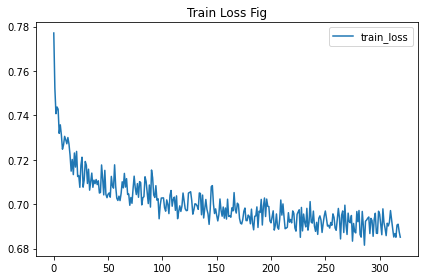


 EPOCH 321/500 	 train loss 0.6838646753392991

 EPOCH 322/500 	 train loss 0.6869148972010849

 EPOCH 323/500 	 train loss 0.6901078995304926

 EPOCH 324/500 	 train loss 0.6866110181651099

 EPOCH 325/500 	 train loss 0.6906373178211376


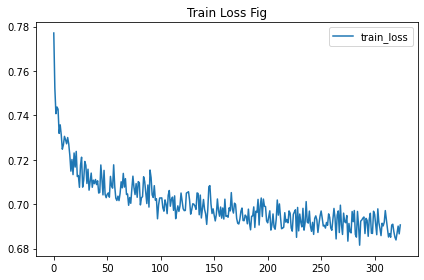


 EPOCH 326/500 	 train loss 0.6839318291188861

 EPOCH 327/500 	 train loss 0.6934682071799099

 EPOCH 328/500 	 train loss 0.6829765244285659

 EPOCH 329/500 	 train loss 0.6837827663610477

 EPOCH 330/500 	 train loss 0.6942586615534112


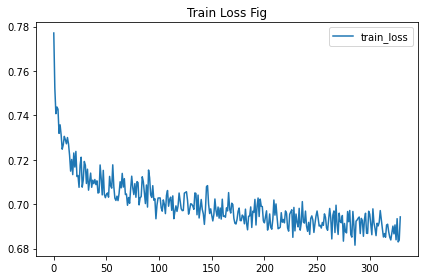


 EPOCH 331/500 	 train loss 0.6897877985888189

 EPOCH 332/500 	 train loss 0.6830530072202777

 EPOCH 333/500 	 train loss 0.6901806179839786

 EPOCH 334/500 	 train loss 0.6864941600132304

 EPOCH 335/500 	 train loss 0.685445527432382


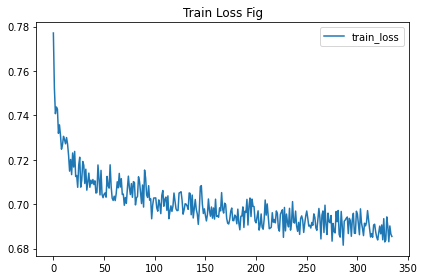


 EPOCH 336/500 	 train loss 0.684757131947936

 EPOCH 337/500 	 train loss 0.6906206175045605

 EPOCH 338/500 	 train loss 0.6923090994554778

 EPOCH 339/500 	 train loss 0.6876704024009579

 EPOCH 340/500 	 train loss 0.6822593739323883


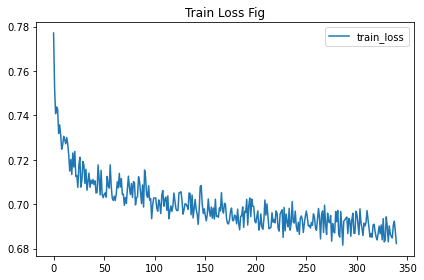


 EPOCH 341/500 	 train loss 0.6827606729941793

 EPOCH 342/500 	 train loss 0.6835979549798241

 EPOCH 343/500 	 train loss 0.6920005685032005

 EPOCH 344/500 	 train loss 0.6861228691075895

 EPOCH 345/500 	 train loss 0.6938072808898321


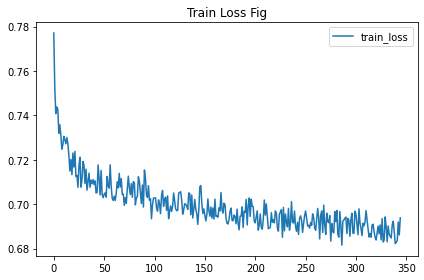


 EPOCH 346/500 	 train loss 0.6881000531388588

 EPOCH 347/500 	 train loss 0.6879572537865969

 EPOCH 348/500 	 train loss 0.6868943633026022

 EPOCH 349/500 	 train loss 0.6869431800968183

 EPOCH 350/500 	 train loss 0.6907244767292892


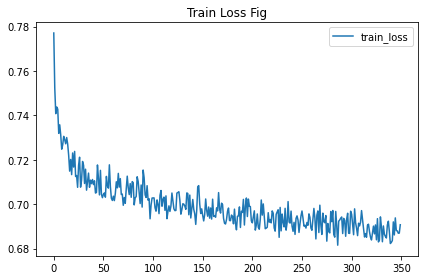


 EPOCH 351/500 	 train loss 0.6924388306369089

 EPOCH 352/500 	 train loss 0.6871822533434374

 EPOCH 353/500 	 train loss 0.6921364057182086

 EPOCH 354/500 	 train loss 0.6945845474897832

 EPOCH 355/500 	 train loss 0.689948569823413


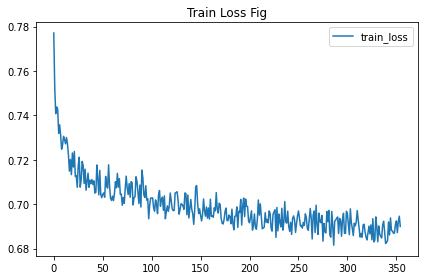


 EPOCH 356/500 	 train loss 0.6851917052819784

 EPOCH 357/500 	 train loss 0.6866656199540242

 EPOCH 358/500 	 train loss 0.6908209835342055

 EPOCH 359/500 	 train loss 0.6889686773319056

 EPOCH 360/500 	 train loss 0.6917480682775919


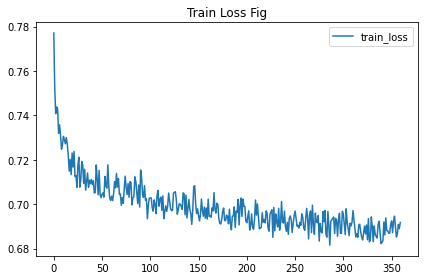


 EPOCH 361/500 	 train loss 0.6837696541260572

 EPOCH 362/500 	 train loss 0.6803978520258032

 EPOCH 363/500 	 train loss 0.6843307230732228

 EPOCH 364/500 	 train loss 0.6876409549524288

 EPOCH 365/500 	 train loss 0.6869707516711144


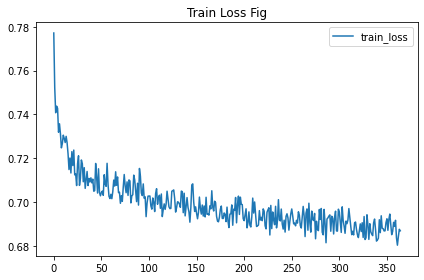


 EPOCH 366/500 	 train loss 0.6917421825648141

 EPOCH 367/500 	 train loss 0.6854478187686933

 EPOCH 368/500 	 train loss 0.6908334662811985

 EPOCH 369/500 	 train loss 0.6822992205226383

 EPOCH 370/500 	 train loss 0.6891169721143867


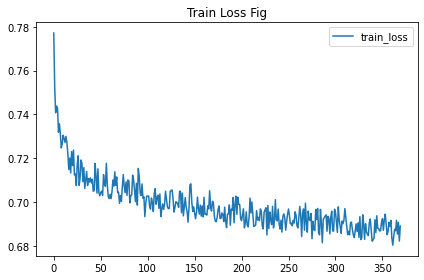


 EPOCH 371/500 	 train loss 0.686928651513833

 EPOCH 372/500 	 train loss 0.6879576440691555

 EPOCH 373/500 	 train loss 0.6908801428162226

 EPOCH 374/500 	 train loss 0.6885624372526364

 EPOCH 375/500 	 train loss 0.6890458714450547


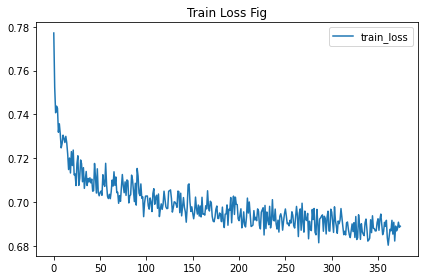


 EPOCH 376/500 	 train loss 0.6865475217107893

 EPOCH 377/500 	 train loss 0.6902909168709229

 EPOCH 378/500 	 train loss 0.6917141955284396

 EPOCH 379/500 	 train loss 0.6894186038782101

 EPOCH 380/500 	 train loss 0.6833681037323703


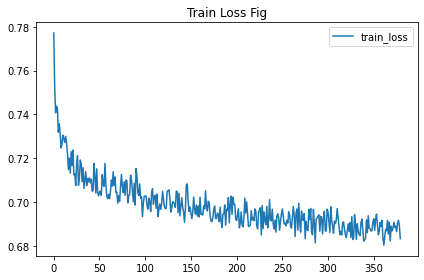


 EPOCH 381/500 	 train loss 0.6898504515292228

 EPOCH 382/500 	 train loss 0.6891698050420276

 EPOCH 383/500 	 train loss 0.6894174707998143

 EPOCH 384/500 	 train loss 0.6895324971416209

 EPOCH 385/500 	 train loss 0.6880871045707476


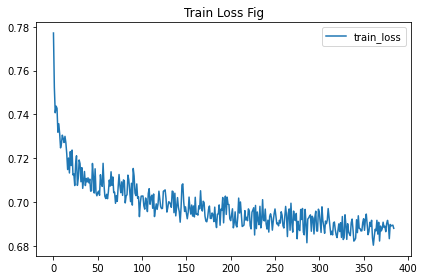


 EPOCH 386/500 	 train loss 0.6942745435355914

 EPOCH 387/500 	 train loss 0.6872663340552805

 EPOCH 388/500 	 train loss 0.6833387444121609

 EPOCH 389/500 	 train loss 0.6898889321305177

 EPOCH 390/500 	 train loss 0.6800817168585145


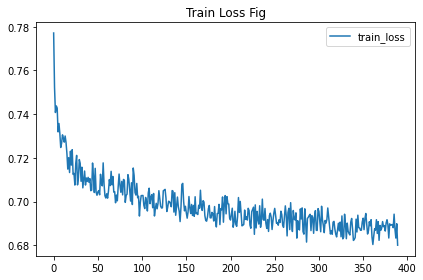


 EPOCH 391/500 	 train loss 0.6885165035134495

 EPOCH 392/500 	 train loss 0.6832601465407772

 EPOCH 393/500 	 train loss 0.6891539923035273

 EPOCH 394/500 	 train loss 0.690384301415371

 EPOCH 395/500 	 train loss 0.690998360662177


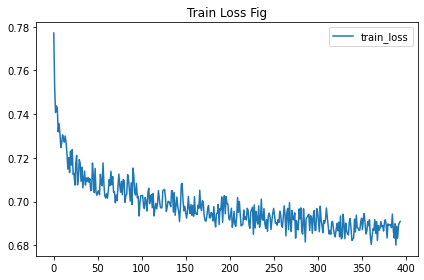


 EPOCH 396/500 	 train loss 0.6892998069032977

 EPOCH 397/500 	 train loss 0.6902314239602672

 EPOCH 398/500 	 train loss 0.684046458883254

 EPOCH 399/500 	 train loss 0.6890676894990524

 EPOCH 400/500 	 train loss 0.6879898990341539


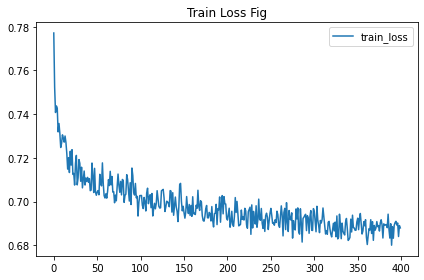


 EPOCH 401/500 	 train loss 0.6795911253875632

 EPOCH 402/500 	 train loss 0.6856713499566509

 EPOCH 403/500 	 train loss 0.6861241595579846

 EPOCH 404/500 	 train loss 0.6909973220069809

 EPOCH 405/500 	 train loss 0.6837313057172416


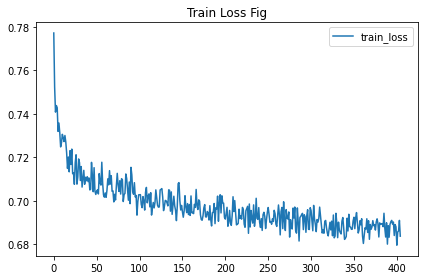


 EPOCH 406/500 	 train loss 0.6839550383413585

 EPOCH 407/500 	 train loss 0.6883622789540307

 EPOCH 408/500 	 train loss 0.6821886887251347

 EPOCH 409/500 	 train loss 0.6878609735973598

 EPOCH 410/500 	 train loss 0.6823652286340695


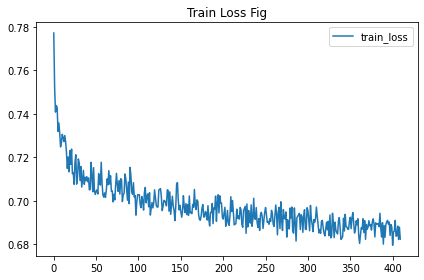


 EPOCH 411/500 	 train loss 0.6787080922142508

 EPOCH 412/500 	 train loss 0.6862287489887905

 EPOCH 413/500 	 train loss 0.6882333849916363

 EPOCH 414/500 	 train loss 0.683629844841784

 EPOCH 415/500 	 train loss 0.6801323151037638


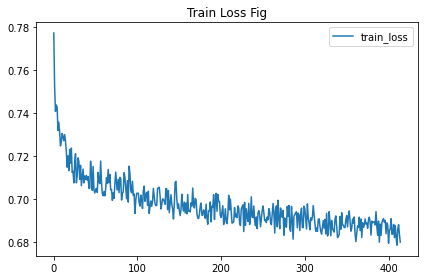


 EPOCH 416/500 	 train loss 0.6830973987138704

 EPOCH 417/500 	 train loss 0.6903448891718396

 EPOCH 418/500 	 train loss 0.6893314827393384

 EPOCH 419/500 	 train loss 0.6843515402413044

 EPOCH 420/500 	 train loss 0.6871318187650675


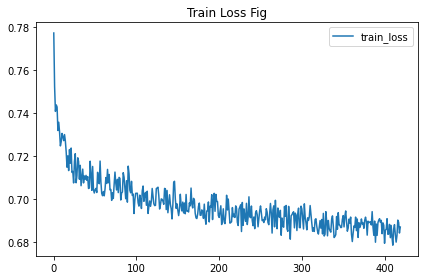


 EPOCH 421/500 	 train loss 0.6861055393030148

 EPOCH 422/500 	 train loss 0.6818338022767121

 EPOCH 423/500 	 train loss 0.6835233984213851

 EPOCH 424/500 	 train loss 0.6833759471528208

 EPOCH 425/500 	 train loss 0.6877122255835203


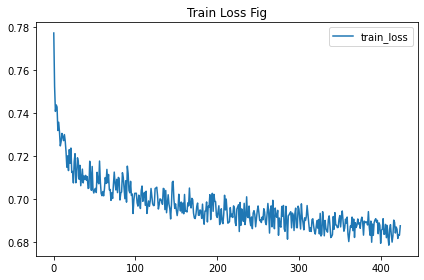


 EPOCH 426/500 	 train loss 0.686815072994421

 EPOCH 427/500 	 train loss 0.6869844304453029

 EPOCH 428/500 	 train loss 0.6825592242451785

 EPOCH 429/500 	 train loss 0.6837447704655109

 EPOCH 430/500 	 train loss 0.6864342327558561


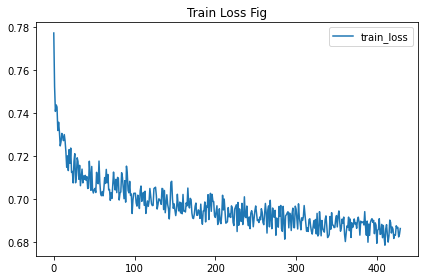


 EPOCH 431/500 	 train loss 0.6856051529988204

 EPOCH 432/500 	 train loss 0.681918745387112

 EPOCH 433/500 	 train loss 0.6839240927113952

 EPOCH 434/500 	 train loss 0.6849177898746905

 EPOCH 435/500 	 train loss 0.6852832202470736


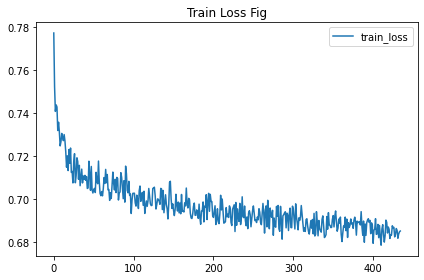


 EPOCH 436/500 	 train loss 0.6871703245458823

 EPOCH 437/500 	 train loss 0.6907540437805377

 EPOCH 438/500 	 train loss 0.6787780535103071

 EPOCH 439/500 	 train loss 0.6807354590286909

 EPOCH 440/500 	 train loss 0.6920903964404619


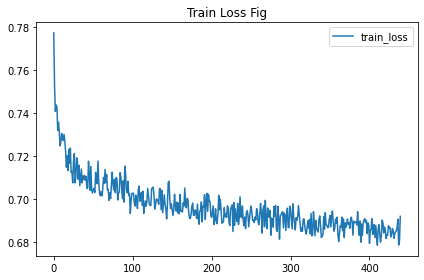


 EPOCH 441/500 	 train loss 0.6780725674267256

 EPOCH 442/500 	 train loss 0.6849944678076817

 EPOCH 443/500 	 train loss 0.6843936278088258

 EPOCH 444/500 	 train loss 0.6830047821447794

 EPOCH 445/500 	 train loss 0.6820504342762157


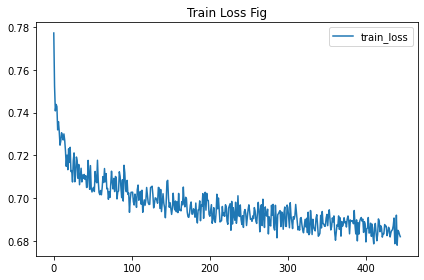


 EPOCH 446/500 	 train loss 0.6790958631156695

 EPOCH 447/500 	 train loss 0.6827585012605875

 EPOCH 448/500 	 train loss 0.6928450455366582

 EPOCH 449/500 	 train loss 0.6836884124050833

 EPOCH 450/500 	 train loss 0.6866929208484813


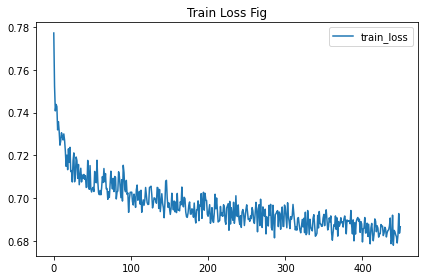


 EPOCH 451/500 	 train loss 0.690643845611673

 EPOCH 452/500 	 train loss 0.6859853826340275

 EPOCH 453/500 	 train loss 0.6805531152404181

 EPOCH 454/500 	 train loss 0.6839515824522516

 EPOCH 455/500 	 train loss 0.6817404869759437


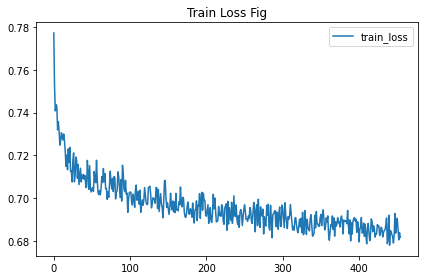


 EPOCH 456/500 	 train loss 0.6898687381555538

 EPOCH 457/500 	 train loss 0.6963208579387602

 EPOCH 458/500 	 train loss 0.6833678141678914

 EPOCH 459/500 	 train loss 0.6804014464022696

 EPOCH 460/500 	 train loss 0.686940869875867


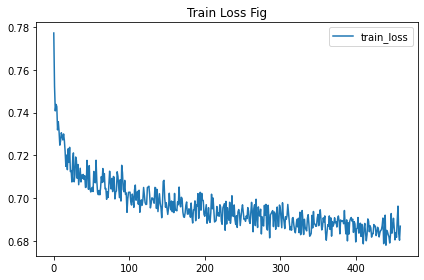


 EPOCH 461/500 	 train loss 0.6910505326274204

 EPOCH 462/500 	 train loss 0.6852730603107918

 EPOCH 463/500 	 train loss 0.6904349626094202

 EPOCH 464/500 	 train loss 0.6831917211954349

 EPOCH 465/500 	 train loss 0.6786378098793155


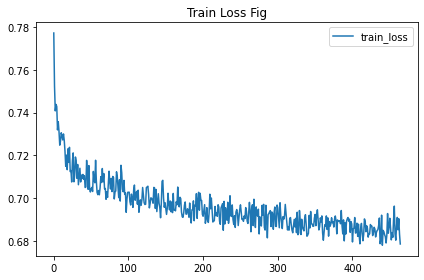


 EPOCH 466/500 	 train loss 0.6893670739907243

 EPOCH 467/500 	 train loss 0.6802716837464386

 EPOCH 468/500 	 train loss 0.687378219251979

 EPOCH 469/500 	 train loss 0.6821544823473437

 EPOCH 470/500 	 train loss 0.6852655819933801


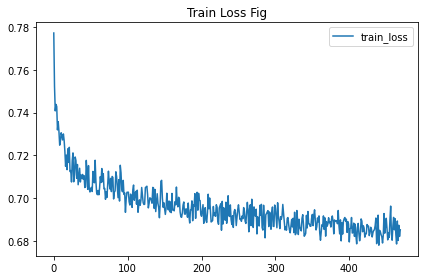


 EPOCH 471/500 	 train loss 0.6898500234773843

 EPOCH 472/500 	 train loss 0.6847652838175052

 EPOCH 473/500 	 train loss 0.6940805290398424

 EPOCH 474/500 	 train loss 0.6775338767778756

 EPOCH 475/500 	 train loss 0.6862481309242374


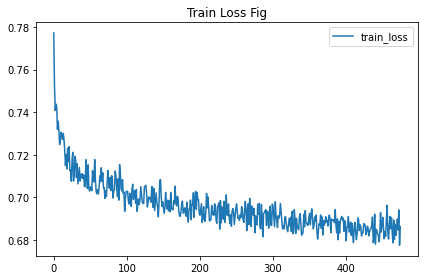


 EPOCH 476/500 	 train loss 0.6828150607571744

 EPOCH 477/500 	 train loss 0.6832321909788025

 EPOCH 478/500 	 train loss 0.6900022147905709

 EPOCH 479/500 	 train loss 0.6856865332071537

 EPOCH 480/500 	 train loss 0.684346894619882


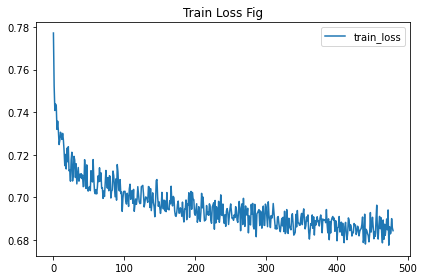


 EPOCH 481/500 	 train loss 0.6789565574217944

 EPOCH 482/500 	 train loss 0.6879387342497068

 EPOCH 483/500 	 train loss 0.688376247292698

 EPOCH 484/500 	 train loss 0.683317492897361

 EPOCH 485/500 	 train loss 0.6858149802330697


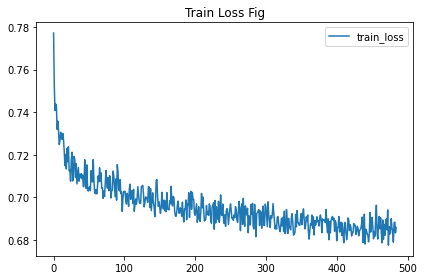


 EPOCH 486/500 	 train loss 0.6815589237527879

 EPOCH 487/500 	 train loss 0.6829116368057704

 EPOCH 488/500 	 train loss 0.6868798724888968

 EPOCH 489/500 	 train loss 0.6809295553578796

 EPOCH 490/500 	 train loss 0.6809017949371842


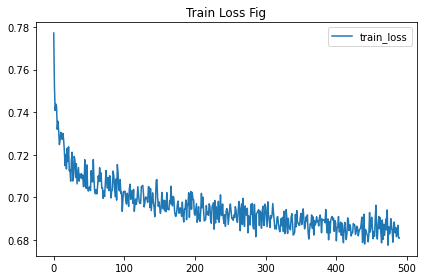


 EPOCH 491/500 	 train loss 0.6801023577699566

 EPOCH 492/500 	 train loss 0.6770290399935379

 EPOCH 493/500 	 train loss 0.691190505578573

 EPOCH 494/500 	 train loss 0.6857174536575972

 EPOCH 495/500 	 train loss 0.6798310799173789


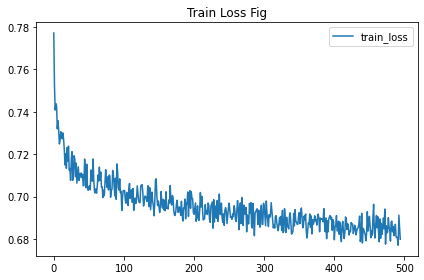


 EPOCH 496/500 	 train loss 0.6781135282107312

 EPOCH 497/500 	 train loss 0.6803230373772851

 EPOCH 498/500 	 train loss 0.6847933400975595

 EPOCH 499/500 	 train loss 0.6870126126229567

 EPOCH 500/500 	 train loss 0.6906960553461963


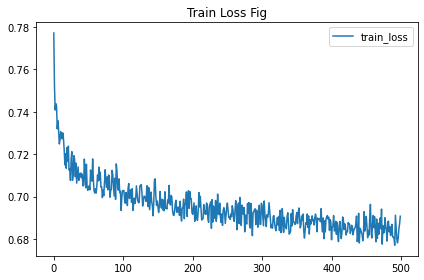

In [8]:
num_epochs = 500
all_loss = {'train_loss':[],'test_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch_mmd(encoder,decoder,output_layer,train_loader_1, train_loader_2,optim,factor_zinb,factor_mmd)
    print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))
    all_loss['train_loss'].append(train_loss)
    all_loss['test_loss'].append(0)
    if epoch and (epoch + 1) % 5 == 0:
        plot_train(all_loss)

### Visualize the latent embedding

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


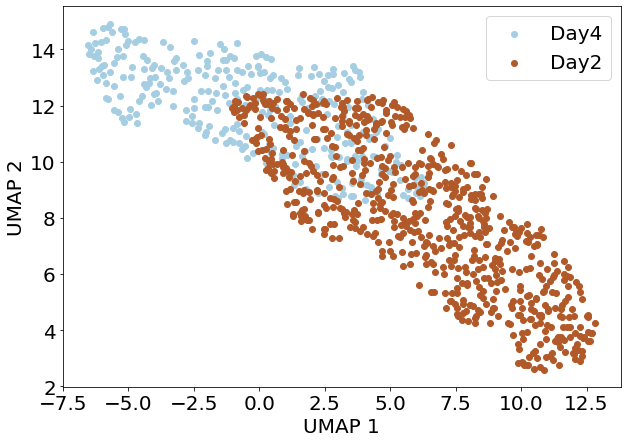

In [9]:
test_loader_2 = DataLoader(train_data_2, batch_size = train_data_2.counts.shape[0], shuffle = False)
test_loader_1 = DataLoader(train_data_1, batch_size = train_data_1.counts.shape[0], shuffle = False)
vis_latent_emb(test_loader_1, test_loader_2, encoder, device)